<img src="imgs/unicamp.png" width="150" height="150">

# Tunning

In [172]:
# Default
import os

# Numerical and IO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# NLP
import pickle
import nltk
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow import keras

# PSO
from pyswarm import pso


import warnings
warnings.filterwarnings("ignore")

## Read Data

In [2]:
folder = 'augmented/'
files_path = os.listdir(folder)
files = {}

# Get in order
for i in range(1, len(files_path)+1):
    
    file = [f for f in files_path if f'{i}' == f.split('_')[0]][0]
    files[file] = pd.read_csv(folder+file)
    files[file].columns = ['question', 'answer']
    files[file].dropna(inplace=True)

### Create corpus

In [3]:
corpus = []

for f in files:
    
    for indx, row in files[f].iterrows():
        
        corpus.append(row['question'])
        corpus.append(row['answer'])

### IO objects

In [4]:
def save(file: str, data):
    
    folder = 'pickles/'
    with open(f'{folder}{file}.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load(file: str):

    folder = 'pickles/'
    with open(f'{folder}{file}.pickle', 'rb') as handle:
        pick = pickle.load(handle)
    
    return pick

## Prepare Data

Prepare data for hierarquical classifier.
- Which subject?
- Which question?

In [9]:
# Which subject?
class_sub = {}
X_sub, y_sub = [], []

for i, f in enumerate(files):

    class_sub[str(i+1)] = f
    X_sub.extend(files[f]['question'].values)
    y_sub.extend([str(i+1)]*len(files[f]['question'].values))

In [10]:
# Which question?
class_que = {}
X_que, y_que = [], []
count = 0
last = ''

for i, f in enumerate(files):
    
    for j, row in files[f].iterrows():
        
        que = row['question']
        ans = row['answer']
        
        if last != ans:
            last = ans
            count += 1
        
        class_que[str(count)] = ans
        X_que.append(que)
        y_que.append(str(count))

### Clean data

In [11]:
X_sub = [x.replace('\n', '') for x in X_sub]
X_que = [x.replace('\n', '') for x in X_que]

In [12]:
len(X_sub), len(y_sub), len(X_que), len(y_que)

(800, 800, 800, 800)

## Modelling

In [13]:
def split_data(X: list, y: list):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [14]:
def get_embedding(text: str):
    
    tokenized = word_tokenize(text.lower())
    return model.infer_vector(tokenized)

In [15]:
def make_it_vector(X: list):
    
    vectors = []
    
    for text in X:
        vectors.append(get_embedding(text))
        
    return vectors

In [16]:
def evaluate(model, X, y):
    
    return cross_val_score(model, X, y, cv=5, scoring='f1_macro')

In [17]:
def get_network(classes_len):
    
    model = keras.Sequential([
        keras.layers.Input(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(classes_len, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [18]:
def one_hot_label(ys):
    
    y_ohe = []
    ys = list(map(int, ys))
    maxi = np.amax(ys)
    
    for y in ys:
        y_ohe.append([1 if i == y else 0 for i in range(maxi)])
    
    return y_ohe

In [174]:
def split_data_per_subject(subject):
    # Get data
    X_que_filt, y_que_filt = get_data_per_subject(subject)

    # Split data
    X_train, X_test, y_train, y_test = split_data(X_que_filt, y_que_filt)

    # Make X vector
    X_train_vec = make_it_vector(X_train)
    X_test_vec = make_it_vector(X_test)

    return X_train_vec, X_test_vec, y_train, y_test

In [175]:
def get_data_per_subject(subject):
    start = (subject-1)*50
    end = start + 50

    X_que_filt = np.array(X_que)[start:end]
    y_que_filt = np.array(y_que)[start:end]

    return X_que_filt, y_que_filt

## Model PSO

In [96]:
class model_pso():
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        super(model_pso, self).__init__()
        
    def model_set(self, model, dict_params, extra_params = {}):
        self.model = model
        self.dict_params = dict_params
        self.extra_params = extra_params

    def model_fit(self, params):
        
        scores = cross_val_score(self.model(**params), self.X, self.y, cv=5, scoring='f1_macro')
        
        return scores.mean()

    def model_optimize(self, params_value):
        '''
        Modelo ajeitado para ser aplicado com o PSO.
        ''' 
        params = self.extra_params
        for key, value in zip(self.dict_params.keys(), params_value):
            params[key] = self.dict_params[key](value)
        
        score = self.model_fit(params)
        
        return 1 - score
    
    def model_predict(self, X_test, y_test, best_params):
        params = self.extra_params
        for key, value in zip(self.dict_params.keys(), best_params):
            params[key] = self.dict_params[key](value)
            
        clf = self.model(**params)
        clf.fit(self.X, self.y)
        pred = clf.predict(X_test)
        return clf, f1_score(y_test, pred, average='macro')
        
        
    

## Subject

In [69]:
# Split data
X_train, X_test, y_train, y_test = split_data(X_sub, y_sub)

# Make X vector
X_train_vec = make_it_vector(X_train)
X_test_vec = make_it_vector(X_test)

In [97]:
m_pso = model_pso(X_train_vec, y_train)

### RandomForest

In [106]:
# Create Model
rf_model = RandomForestClassifier(random_state=42)

# Evaluate
evaluate(rf_model, X_train_vec, y_train)

# Fit and test
rf_model.fit(X_train_vec, y_train)
pred = rf_model.predict(X_test_vec)

print(f"f1-Score for {rf_model} using train dataset = {evaluate(rf_model, X_train_vec, y_train).mean()}")
print(f"f1-Score for {rf_model} using test dataset = {f1_score(y_test, pred, average='macro')}")

f1-Score for RandomForestClassifier(random_state=42) using train dataset = 0.7487754934936588
f1-Score for RandomForestClassifier(random_state=42) using test dataset = 0.8530094905094905


In [98]:
# Create Model
rf_model = RandomForestClassifier

# Set hyperparameters to optimize and variables's type
param_to_opt = {'ccp_alpha' : float, 'n_estimators' : int}

# Set lower and upper boundarys
lb = [0.0, 1]
ub = [0.04, 300]

# Set model in class
m_pso.model_set(rf_model, param_to_opt, extra_params= {'random_state' : 42})

# Seek best hyperparameters
best_pso = pso(m_pso.model_optimize, lb, ub, swarmsize= 11, maxiter= 11, debug = True)

No constraints given.
New best for swarm at iteration 1: [ 0.         74.69157443] 0.26131525647909926
New best for swarm at iteration 1: [  0.         204.45090028] 0.23258916745449254
Best after iteration 1: [  0.         204.45090028] 0.23258916745449254
New best for swarm at iteration 2: [  0.         179.91192881] 0.23228728892796235
Best after iteration 2: [  0.         179.91192881] 0.23228728892796235
New best for swarm at iteration 3: [  0.         286.98393573] 0.2230096429842946
Best after iteration 3: [  0.         286.98393573] 0.2230096429842946
New best for swarm at iteration 4: [  0.         280.47590359] 0.2217753378587357
New best for swarm at iteration 4: [  0.         276.61437201] 0.21977159431499682
Best after iteration 4: [  0.         276.61437201] 0.21977159431499682
New best for swarm at iteration 5: [  0.         277.07917241] 0.21947981093497815
Best after iteration 5: [  0.         277.07917241] 0.21947981093497815
Best after iteration 6: [  0.         277.

In [105]:
model_test, test_score = m_pso.model_predict(X_test_vec, y_test, best_pso[0])
print(f"f1-Score for {model_test} using train dataset = {evaluate(model_test, X_train_vec, y_train).mean()}")
print(f"f1-Score for {model_test} using test dataset = {test_score}")

f1-Score for RandomForestClassifier(n_estimators=277, random_state=42) using train dataset = 0.7805201890650219
f1-Score for RandomForestClassifier(n_estimators=277, random_state=42) using test dataset = 0.8718649406149406


### MLPClassifier

In [110]:
# Create Model
mlp_model = MLPClassifier(max_iter=300, random_state=42)

# Evaluate
evaluate(mlp_model, X_train_vec, y_train)

# Fit and test
mlp_model.fit(X_train_vec, y_train)
pred = mlp_model.predict(X_test_vec)
f1_score(y_test, pred, average='macro')

print(f"f1-Score for {mlp_model} using train dataset = {evaluate(mlp_model, X_train_vec, y_train).mean()}")
print(f"f1-Score for {mlp_model} using test dataset = {f1_score(y_test, pred, average='macro')}")

f1-Score for MLPClassifier(max_iter=300, random_state=42) using train dataset = 0.7534351410888883
f1-Score for MLPClassifier(max_iter=300, random_state=42) using test dataset = 0.7338108072483072


In [108]:
# Create Model
mlp_model = MLPClassifier

# Set hyperparameters to optimize and variables's type
param_to_opt = {'hidden_layer_sizes' : int}

# Set lower and upper boundarys
lb = [3]
ub = [100]

# Set model in class
m_pso.model_set(mlp_model, param_to_opt, extra_params= {'max_iter': 200, 'random_state':42})

# Seek best hyperparameters
best_pso = pso(m_pso.model_optimize, lb, ub, swarmsize= 11, maxiter= 11, debug = True)

No constraints given.
New best for swarm at iteration 1: [50.] 0.2818760410621446
Best after iteration 1: [50.] 0.2818760410621446
Best after iteration 2: [50.] 0.2818760410621446
Best after iteration 3: [50.] 0.2818760410621446
New best for swarm at iteration 4: [39.27177584] 0.2732395696212748
Best after iteration 4: [39.27177584] 0.2732395696212748
Best after iteration 5: [39.27177584] 0.2732395696212748
Best after iteration 6: [39.27177584] 0.2732395696212748
Best after iteration 7: [39.27177584] 0.2732395696212748
Best after iteration 8: [39.27177584] 0.2732395696212748
Best after iteration 9: [39.27177584] 0.2732395696212748
Best after iteration 10: [39.27177584] 0.2732395696212748
Best after iteration 11: [39.27177584] 0.2732395696212748
Stopping search: maximum iterations reached --> 11


In [109]:
model_test, test_score = m_pso.model_predict(X_test_vec, y_test, best_pso[0])
print(f"f1-Score for {model_test} using train dataset = {evaluate(model_test, X_train_vec, y_train).mean()}")
print(f"f1-Score for {model_test} using test dataset = {test_score}")

f1-Score for MLPClassifier(hidden_layer_sizes=39, max_iter=300, random_state=42) using train dataset = 0.7267604303787252
f1-Score for MLPClassifier(hidden_layer_sizes=39, max_iter=300, random_state=42) using test dataset = 0.7049761104908163


### Gradient Boosting

In [115]:
# Create Model
gb_model = GradientBoostingClassifier(random_state=42)

# Evaluate
evaluate(gb_model, X_train_vec, y_train)

# Fit and test
gb_model.fit(X_train_vec, y_train)
pred = gb_model.predict(X_test_vec)
f1_score(y_test, pred, average='macro')

print(f"f1-Score for {gb_model} using train dataset = {evaluate(gb_model, X_train_vec, y_train).mean()}")
print(f"f1-Score for {gb_model} using test dataset = {f1_score(y_test, pred, average='macro')}")

f1-Score for GradientBoostingClassifier(random_state=42) using train dataset = 0.6007712358693563
f1-Score for GradientBoostingClassifier(random_state=42) using test dataset = 0.6561135045510046


In [113]:
# Create Model
gb_model = GradientBoostingClassifier

# Set hyperparameters to optimize and variables's type
param_to_opt = {'n_estimators' : int, 'learning_rate': float}

# Set lower and upper boundarys
lb = [5, 0.01]
ub = [100, 0.3]

# Set model in class
m_pso.model_set(gb_model, param_to_opt, extra_params= {'random_state':42, 'max_depth' : 3})

# Seek best hyperparameters
best_pso = pso(m_pso.model_optimize, lb, ub, swarmsize= 11, maxiter= 11, debug = True)

No constraints given.
New best for swarm at iteration 1: [95.98239272  0.26111844] 0.36838689960896853
New best for swarm at iteration 1: [100.    0.3] 0.3612329427108839
Best after iteration 1: [100.    0.3] 0.3612329427108839
New best for swarm at iteration 2: [88.72164508  0.3       ] 0.35677324205087024
Best after iteration 2: [88.72164508  0.3       ] 0.35677324205087024
Best after iteration 3: [88.72164508  0.3       ] 0.35677324205087024
New best for swarm at iteration 4: [99.09639013  0.26040618] 0.35477606571704867
Best after iteration 4: [99.09639013  0.26040618] 0.35477606571704867
New best for swarm at iteration 5: [99.41481293  0.29981526] 0.3448274189335738
Best after iteration 5: [99.41481293  0.29981526] 0.3448274189335738
New best for swarm at iteration 6: [99.19509287  0.2997229 ] 0.3423776351796526
Best after iteration 6: [99.19509287  0.2997229 ] 0.3423776351796526
Best after iteration 7: [99.19509287  0.2997229 ] 0.3423776351796526
Best after iteration 8: [99.19509

In [114]:
model_test, test_score = m_pso.model_predict(X_test_vec, y_test, best_pso[0])
print(f"f1-Score for {model_test} using train dataset = {evaluate(model_test, X_train_vec, y_train).mean()}")
print(f"f1-Score for {model_test} using test dataset = {test_score}")

f1-Score for GradientBoostingClassifier(learning_rate=0.2997228955422446, n_estimators=99,
                           random_state=42) using train dataset = 0.6576223648203474
f1-Score for GradientBoostingClassifier(learning_rate=0.2997228955422446, n_estimators=99,
                           random_state=42) using test dataset = 0.6601924117549118


### Logistic Regression

In [119]:
# Create Model
lr_model = LogisticRegression(random_state=42)

# Evaluate
evaluate(lr_model, X_train_vec, y_train)

# Fit and test
lr_model.fit(X_train_vec, y_train)
pred = lr_model.predict(X_test_vec)
f1_score(y_test, pred, average='macro')

print(f"f1-Score for {lr_model} using train dataset = {evaluate(lr_model, X_train_vec, y_train).mean()}")
print(f"f1-Score for {lr_model} using test dataset = {f1_score(y_test, pred, average='macro')}")

f1-Score for LogisticRegression(random_state=42) using train dataset = 0.6473471869977288
f1-Score for LogisticRegression(random_state=42) using test dataset = 0.6513659951159951


In [2]:
best_hip = {
    "RandomForestClassifier" :{
        "best_hip" : {"n_estimators" : 277, "ccp_alpha" : 0.0, "random_state" : 42},
        "f1_score_train" : 0.7805201890650219,
        "f1_score_test" : 0.8718649406149406      
    },
    "RandomForestClassifier_Default" :{
        "best_hip" : {"random_state" : 42},
        "f1_score_train" : 0.7487754934936588,
        "f1_score_test" : 0.8530094905094905      
    },
    "MLPClassifier" :{
        "best_hip" : {"max_iter" : 200, "random_state" : 42, "hidden_layer_sizes" : 39},
        "f1_score_train" : 0.7267604303787252,
        "f1_score_test" : 0.7049761104908163      
    },
    "MLPClassifier_Default" :{
        "best_hip" : {"max_iter" : 300, "random_state" : 42},
        "f1_score_train" : 0.7534351410888883,
        "f1_score_test" : 0.7338108072483072      
    },
    "GradientBoostingClassifier" :{
        "best_hip" : {"learning_rate" : 0.2997228955422446, "n_estimators" : 99, "random_state" : 42},
        "f1_score_train" : 0.6576223648203474,
        "f1_score_test" : 0.6601924117549118      
    },
    "GradientBoostingClassifier_Default" :{
        "best_hip" : {"random_state" : 42},
        "f1_score_train" : 0.6007712358693563,
        "f1_score_test" : 0.6561135045510046      
    },
    "LogisticRegression_Default" :{
        "best_hip" : {"random_state" : 42},
        "f1_score_train" : 0.6473471869977288,
        "f1_score_test" : 0.6513659951159951      
    },
    
}

save("best_models_subject", best_hip)

## Question

In [124]:
subject = 1

start = (subject-1)*50
end = start + 50

X_que_filt = np.array(X_que)[start:end]
y_que_filt = np.array(y_que)[start:end]

In [125]:
# Split data
X_train, X_test, y_train, y_test = split_data(X_que_filt, y_que_filt)

# Make X vector
X_train_vec = make_it_vector(X_train)
X_test_vec = make_it_vector(X_test)

In [130]:
m_pso = model_pso(X_train_vec, y_train)

### RandomForest

In [131]:
# Create Model
rf_model = RandomForestClassifier(random_state=42)

# Evaluate
evaluate(rf_model, X_train_vec, y_train)

# Fit and test
rf_model.fit(X_train_vec, y_train)
pred = rf_model.predict(X_test_vec)

print(f"f1-Score for {rf_model} using train dataset = {evaluate(rf_model, X_train_vec, y_train).mean()}")
print(f"f1-Score for {rf_model} using test dataset = {f1_score(y_test, pred, average='macro')}")

f1-Score for RandomForestClassifier(random_state=42) using train dataset = 0.9703703703703704
f1-Score for RandomForestClassifier(random_state=42) using test dataset = 1.0


In [132]:
# Create Model
rf_model = RandomForestClassifier

# Set hyperparameters to optimize and variables's type
param_to_opt = {'ccp_alpha' : float, 'n_estimators' : int}

# Set lower and upper boundarys
lb = [0.0, 1]
ub = [0.04, 300]

# Set model in class
m_pso.model_set(rf_model, param_to_opt, extra_params= {'random_state' : 42})

# Seek best hyperparameters
best_pso = pso(m_pso.model_optimize, lb, ub, swarmsize= 11, maxiter= 11, debug = True)

No constraints given.
New best for swarm at iteration 1: [  0.         115.87394552] 0.02962962962962956
Stopping search: Swarm best objective change less than 1e-08


In [133]:
model_test, test_score = m_pso.model_predict(X_test_vec, y_test, best_pso[0])
print(f"f1-Score for {model_test} using train dataset = {evaluate(model_test, X_train_vec, y_train).mean()}")
print(f"f1-Score for {model_test} using test dataset = {test_score}")

f1-Score for RandomForestClassifier(n_estimators=115, random_state=42) using train dataset = 0.9703703703703704
f1-Score for RandomForestClassifier(n_estimators=115, random_state=42) using test dataset = 1.0


### MLPClassifier

In [134]:
# Create Model
mlp_model = MLPClassifier(max_iter=300, random_state=42)

# Evaluate
evaluate(mlp_model, X_train_vec, y_train)

# Fit and test
mlp_model.fit(X_train_vec, y_train)
pred = mlp_model.predict(X_test_vec)
f1_score(y_test, pred, average='macro')

print(f"f1-Score for {mlp_model} using train dataset = {evaluate(mlp_model, X_train_vec, y_train).mean()}")
print(f"f1-Score for {mlp_model} using test dataset = {f1_score(y_test, pred, average='macro')}")

f1-Score for MLPClassifier(max_iter=300, random_state=42) using train dataset = 1.0
f1-Score for MLPClassifier(max_iter=300, random_state=42) using test dataset = 1.0


In [135]:
# Create Model
mlp_model = MLPClassifier

# Set hyperparameters to optimize and variables's type
param_to_opt = {'hidden_layer_sizes' : int}

# Set lower and upper boundarys
lb = [3]
ub = [100]

# Set model in class
m_pso.model_set(mlp_model, param_to_opt, extra_params= {'max_iter': 200, 'random_state':42})

# Seek best hyperparameters
best_pso = pso(m_pso.model_optimize, lb, ub, swarmsize= 11, maxiter= 11, debug = True)

No constraints given.
Best after iteration 1: [62.45819404] 0.0
Best after iteration 2: [62.45819404] 0.0
Best after iteration 3: [62.45819404] 0.0
Best after iteration 4: [62.45819404] 0.0
Best after iteration 5: [62.45819404] 0.0
Best after iteration 6: [62.45819404] 0.0
Best after iteration 7: [62.45819404] 0.0
Best after iteration 8: [62.45819404] 0.0
Best after iteration 9: [62.45819404] 0.0
Best after iteration 10: [62.45819404] 0.0
Best after iteration 11: [62.45819404] 0.0
Stopping search: maximum iterations reached --> 11


In [136]:
model_test, test_score = m_pso.model_predict(X_test_vec, y_test, best_pso[0])
print(f"f1-Score for {model_test} using train dataset = {evaluate(model_test, X_train_vec, y_train).mean()}")
print(f"f1-Score for {model_test} using test dataset = {test_score}")

f1-Score for MLPClassifier(hidden_layer_sizes=62, random_state=42) using train dataset = 1.0
f1-Score for MLPClassifier(hidden_layer_sizes=62, random_state=42) using test dataset = 1.0


### GradientBoosting

In [137]:
# Create Model
gb_model = GradientBoostingClassifier(random_state=42)

# Evaluate
evaluate(gb_model, X_train_vec, y_train)

# Fit and test
gb_model.fit(X_train_vec, y_train)
pred = gb_model.predict(X_test_vec)
f1_score(y_test, pred, average='macro')

print(f"f1-Score for {gb_model} using train dataset = {evaluate(gb_model, X_train_vec, y_train).mean()}")
print(f"f1-Score for {gb_model} using test dataset = {f1_score(y_test, pred, average='macro')}")

f1-Score for GradientBoostingClassifier(random_state=42) using train dataset = 0.7222222222222221
f1-Score for GradientBoostingClassifier(random_state=42) using test dataset = 1.0


In [138]:
# Create Model
gb_model = GradientBoostingClassifier

# Set hyperparameters to optimize and variables's type
param_to_opt = {'n_estimators' : int, 'learning_rate': float}

# Set lower and upper boundarys
lb = [5, 0.01]
ub = [100, 0.3]

# Set model in class
m_pso.model_set(gb_model, param_to_opt, extra_params= {'random_state':42, 'max_depth' : 3})

# Seek best hyperparameters
best_pso = pso(m_pso.model_optimize, lb, ub, swarmsize= 11, maxiter= 11, debug = True)

No constraints given.
Best after iteration 1: [17.17444637  0.19116703] 0.24814814814814823
New best for swarm at iteration 2: [5.         0.12771015] 0.21851851851851856
Best after iteration 2: [5.         0.12771015] 0.21851851851851856
Best after iteration 3: [5.         0.12771015] 0.21851851851851856
Best after iteration 4: [5.         0.12771015] 0.21851851851851856
Best after iteration 5: [5.         0.12771015] 0.21851851851851856
Best after iteration 6: [5.         0.12771015] 0.21851851851851856
Best after iteration 7: [5.         0.12771015] 0.21851851851851856
Best after iteration 8: [5.         0.12771015] 0.21851851851851856
Best after iteration 9: [5.         0.12771015] 0.21851851851851856
New best for swarm at iteration 10: [5.        0.1322785] 0.1955555555555556
Best after iteration 10: [5.        0.1322785] 0.1955555555555556
Best after iteration 11: [5.        0.1322785] 0.1955555555555556
Stopping search: maximum iterations reached --> 11


In [139]:
model_test, test_score = m_pso.model_predict(X_test_vec, y_test, best_pso[0])
print(f"f1-Score for {model_test} using train dataset = {evaluate(model_test, X_train_vec, y_train).mean()}")
print(f"f1-Score for {model_test} using test dataset = {test_score}")

f1-Score for GradientBoostingClassifier(learning_rate=0.13227850217356052, n_estimators=5,
                           random_state=42) using train dataset = 0.8044444444444444
f1-Score for GradientBoostingClassifier(learning_rate=0.13227850217356052, n_estimators=5,
                           random_state=42) using test dataset = 1.0


### Logistic Regression

In [141]:
# Create Model
lr_model = LogisticRegression(random_state=42)

# Evaluate
evaluate(lr_model, X_train_vec, y_train)

# Fit and test
lr_model.fit(X_train_vec, y_train)
pred = lr_model.predict(X_test_vec)
f1_score(y_test, pred, average='macro')

print(f"f1-Score for {lr_model} using train dataset = {evaluate(lr_model, X_train_vec, y_train).mean()}")
print(f"f1-Score for {lr_model} using test dataset = {f1_score(y_test, pred, average='macro')}")

f1-Score for LogisticRegression(random_state=42) using train dataset = 1.0
f1-Score for LogisticRegression(random_state=42) using test dataset = 1.0


In [157]:
best_hip = {
    "RandomForestClassifier" :{
        "best_hip" : {"n_estimators" : 115, "ccp_alpha" : 0.0, "random_state" : 42},
        "f1_score_train" : 0.9703703703703704,
        "f1_score_test" : 1.0      
    },
    "RandomForestClassifier_Default" :{
        "best_hip" : {"random_state" : 42},
        "f1_score_train" : 0.9703703703703704,
        "f1_score_test" : 1.0     
    },
    "MLPClassifier" :{
        "best_hip" : {"max_iter" : 200, "random_state" : 42, "hidden_layer_sizes" : 62},
        "f1_score_train" : 1.0,
        "f1_score_test" : 1.0
    },
    "MLPClassifier_Default" :{
        "best_hip" : {"max_iter" : 300, "random_state" : 42},
        "f1_score_train" : 1.0,
        "f1_score_test" : 1.0
    },
    "GradientBoostingClassifier" :{
        "best_hip" : {"learning_rate" : 0.13227850217356052, "n_estimators" : 5, "random_state" : 42},
        "f1_score_train" : 0.8044444444444444,
        "f1_score_test" : 1.0      
    },
    "GradientBoostingClassifier_Default" :{
        "best_hip" : {"random_state" : 42},
        "f1_score_train" : 0.7222222222222221,
        "f1_score_test" : 1.0      
    },
    "LogisticRegression_Default" :{
        "best_hip" : {"random_state" : 42},
        "f1_score_train" : 1.0,
        "f1_score_test" : 1.0
    },
    
}

save("best_models_question", best_hip)

## Compare and Select

In [148]:
pd.DataFrame.from_dict(load("best_models_subject"), orient='index')

,best_hip,f1_score_train,f1_score_test
RandomForestClassifier,"{'n_estimators': 277, 'cpp_alpha': 0.0, 'rando...",0.780520,0.871865
RandomForestClassifier_Default,{'random_state': 42},0.748775,0.853009
MLPClassifier,"{'max_iter': 200, 'random_state': 42, 'hidden_...",0.726760,0.704976
MLPClassifier_Default,"{'max_iter': 300, 'random_state': 42}",0.753435,0.733811
GradientBoostingClassifier,"{'learning_rate': 0.2997228955422446, 'n_estim...",0.657622,0.660192
GradientBoostingClassifier_Default,{'random_state': 42},0.600771,0.656114
LogisticRegression_Default,{'random_state': 42},0.647347,0.651366


In [149]:
pd.DataFrame.from_dict(load("best_models_question"), orient='index')

,best_hip,f1_score_train,f1_score_test
RandomForestClassifier,"{'n_estimators': 115, 'cpp_alpha': 0.0, 'rando...",0.970370,1.0
RandomForestClassifier_Default,{'random_state': 42},0.970370,1.0
MLPClassifier,"{'max_iter': 200, 'random_state': 42, 'hidden_...",1.000000,1.0
MLPClassifier_Default,"{'max_iter': 300, 'random_state': 42}",1.000000,1.0
GradientBoostingClassifier,"{'learning_rate': 0.13227850217356052, 'n_esti...",0.804444,1.0
GradientBoostingClassifier_Default,{'random_state': 42},0.722222,1.0
LogisticRegression_Default,{'random_state': 42},1.000000,1.0


## Selection Tunning

### Subject

In [150]:
# Split data
X_train, X_test, y_train, y_test = split_data(X_sub, y_sub)

# Make X vector
X_train_vec = make_it_vector(X_train)
X_test_vec = make_it_vector(X_test)

In [159]:
def model_train(model, params, X_train_vec, y_train, X_test_vec, y_test):
    # Create Model
    clf = model(**params)

    # Evaluate
    cv_score = evaluate(clf, X_train_vec, y_train).mean()

    # Fit and test
    clf.fit(X_train_vec, y_train)
    pred = clf.predict(X_test_vec)
    test_score = f1_score(y_test, pred, average='macro')

    return model, cv_score, test_score

hyperparams = load("best_models_subject")

In [165]:
def plot_metrics(train_scores, test_scores, title=None):
    x = np.arange(4)
    width = 0.3

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    ax.bar(x, train_scores, width, label='Cross validation score')
    ax.bar(x + width, test_scores, width, label='F1 score')
    ax.set_title(title)
    ax.set_axisbelow(True)
    ax.grid()
    ax.legend(bbox_to_anchor=(1.05, 0.6))
    plt.xticks(x + width / 2, ('Random Forest','MLP','Gradient Boosting','Logistic Regression'))
    plt.show()

In [167]:
def save_selection_models(models, names):
    for model, name in zip(models, names):
        save('selection/' + name, rf_model)

In [160]:
# Random Forest

rf_model, rf_train_score, rf_test_score = model_train(RandomForestClassifier, 
                                                      hyperparams['RandomForestClassifier']['best_hip'],
                                                      X_train_vec, y_train, X_test_vec, y_test)

In [161]:
save("sub_tunning_model", rf_model)

In [163]:
# MLP classifier

mlp_model, mlp_train_score, mlp_test_score = model_train(MLPClassifier, 
                                                      hyperparams['MLPClassifier_Default']['best_hip'],
                                                      X_train_vec, y_train, X_test_vec, y_test)

In [169]:
# Gradient boosting classifier
gb_model, gb_train_score, gb_test_score = model_train(GradientBoostingClassifier, 
                                                      hyperparams['GradientBoostingClassifier']['best_hip'],
                                                      X_train_vec, y_train, X_test_vec, y_test)

In [170]:
# Logistic regression
lr_model, lr_train_score, lr_test_score = model_train(LogisticRegression, 
                                                      hyperparams['LogisticRegression_Default']['best_hip'],
                                                      X_train_vec, y_train, X_test_vec, y_test)

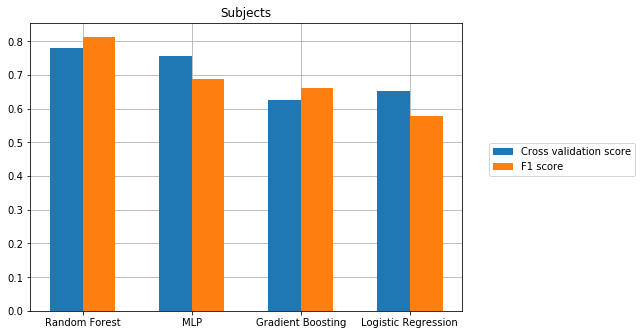

In [173]:
# Subject
# Saving models
models = [rf_model, mlp_model, gb_model, lr_model]
names = ['sub_tunning_rf_model', 'sub_tunning_mlp_model', 'sub_tunning_gb_model', 'sub_tunning_lr_model']
save_selection_models(models, names)

# Plots
train_scores = [rf_train_score, mlp_train_score, gb_train_score, lr_train_score]
test_scores = [rf_test_score, mlp_test_score, gb_test_score, lr_test_score]
plot_metrics(train_scores, test_scores, 'Subjects')

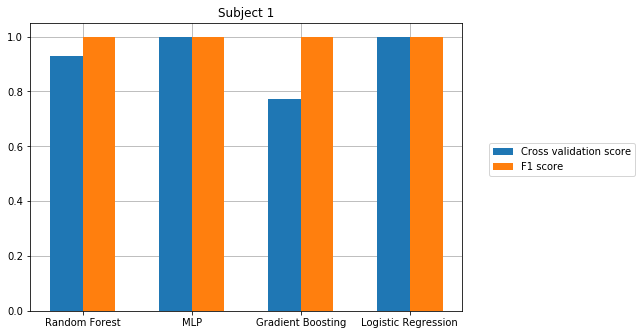

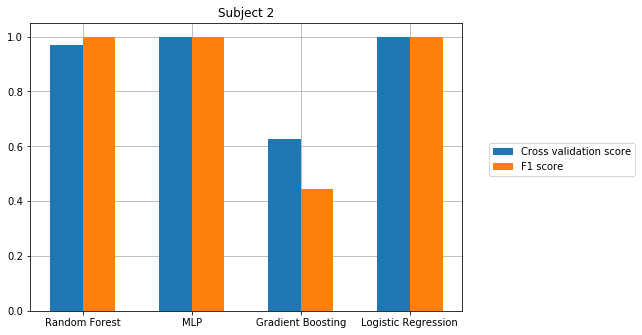

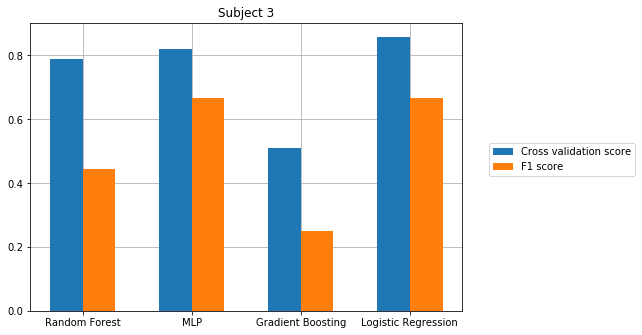

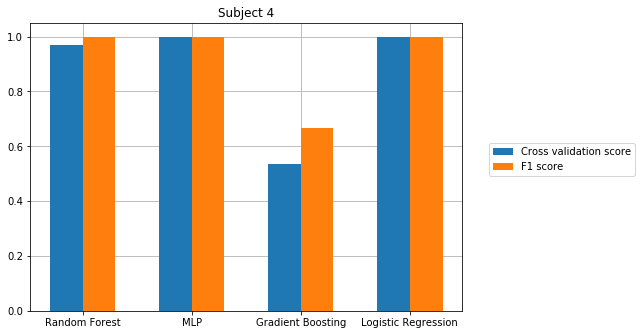

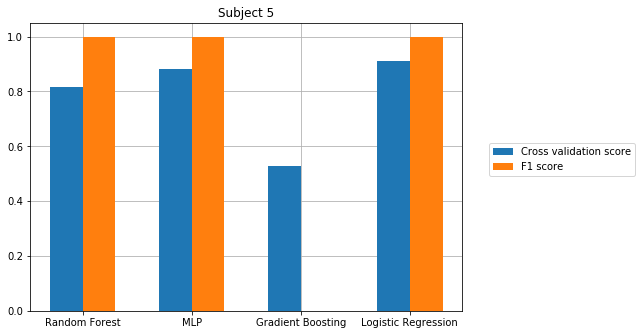

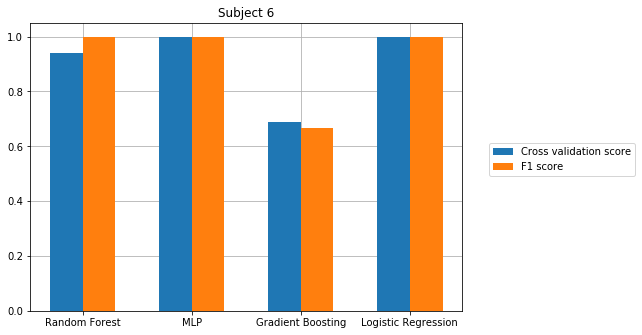

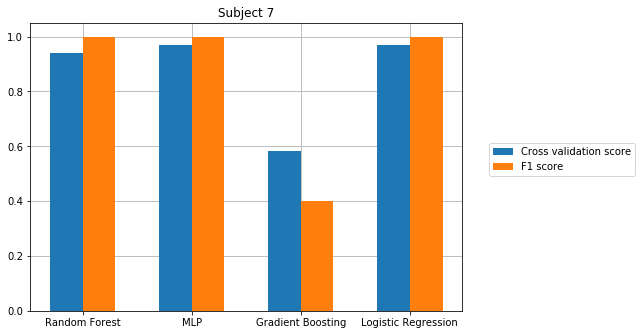

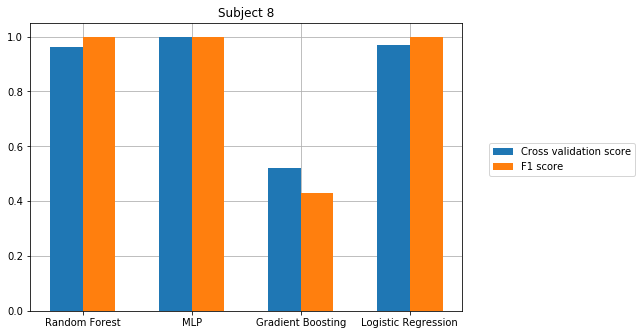

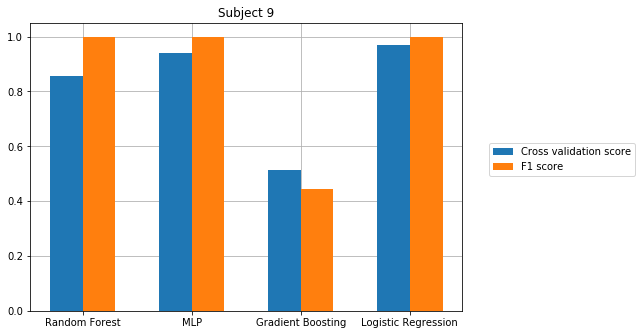

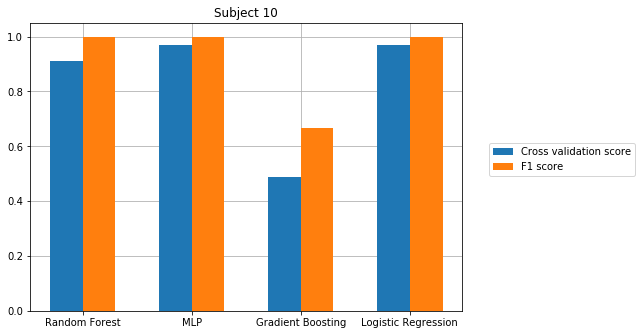

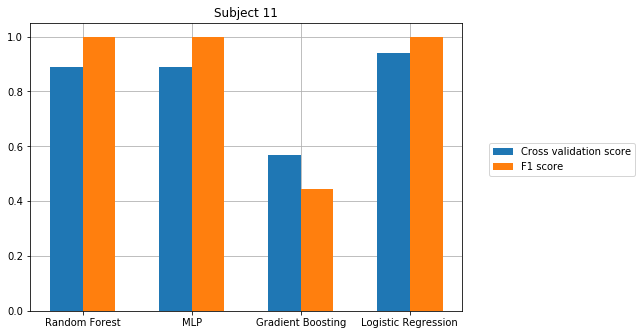

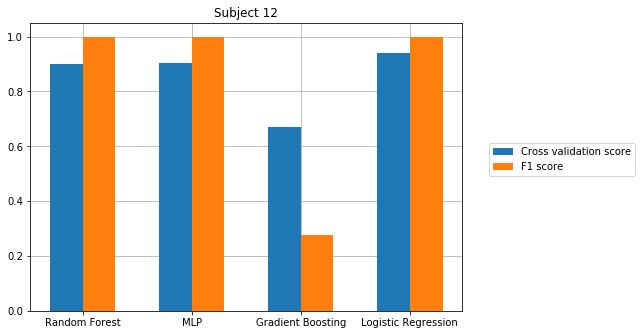

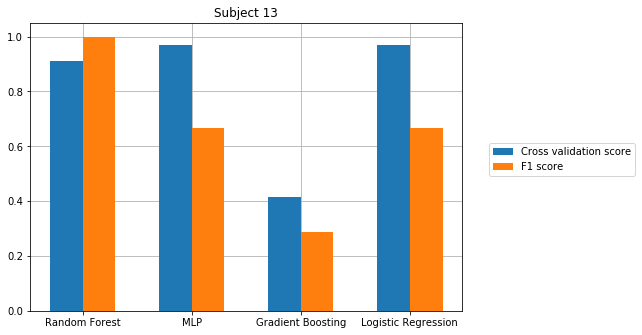

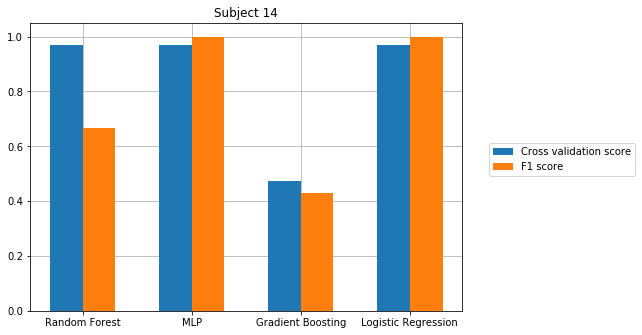

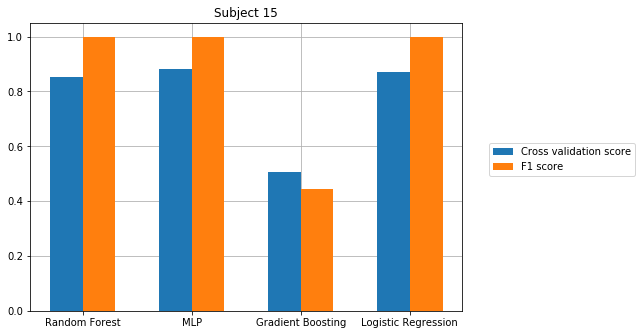

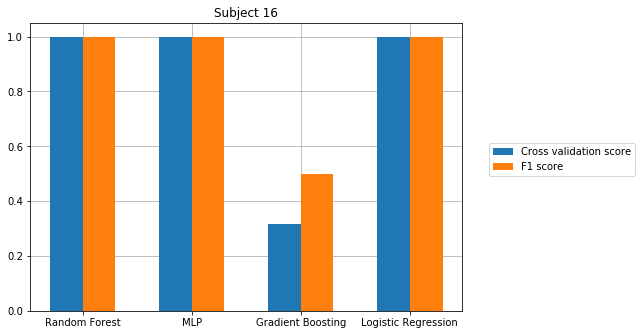

In [176]:
# Questions
for subject in range(1, 17):
    X_train_vec, X_test_vec, y_train, y_test = split_data_per_subject(subject)

    rf_model, rf_train_score, rf_test_score = model_train(RandomForestClassifier, 
                                                      hyperparams['RandomForestClassifier']['best_hip'],
                                                      X_train_vec, y_train, X_test_vec, y_test)
    
    mlp_model, mlp_train_score, mlp_test_score = model_train(MLPClassifier, 
                                                      hyperparams['MLPClassifier_Default']['best_hip'],
                                                      X_train_vec, y_train, X_test_vec, y_test)
    
    gb_model, gb_train_score, gb_test_score = model_train(GradientBoostingClassifier, 
                                                      hyperparams['GradientBoostingClassifier']['best_hip'],
                                                      X_train_vec, y_train, X_test_vec, y_test)
    
    lr_model, lr_train_score, lr_test_score = model_train(LogisticRegression, 
                                                      hyperparams['LogisticRegression_Default']['best_hip'],
                                                      X_train_vec, y_train, X_test_vec, y_test)

    # Saving models
    models = [rf_model, mlp_model, gb_model, lr_model]
    names = [f'{subject}_tunning_rf_que_model', f'{subject}_tunning_mlp_que_model', f'{subject}_tunning_gb_que_model', f'{subject}_tunning_lr_que_model']
    save_selection_models(models, names)

    # Plots
    train_scores = [rf_train_score, mlp_train_score, gb_train_score, lr_train_score]
    test_scores = [rf_test_score, mlp_test_score, gb_test_score, lr_test_score]
    plot_metrics(train_scores, test_scores, 'Subject {}'.format(subject))